In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.se = SELayer(32)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.conv = nn.Conv2d(32, 3, 3, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.se(x)
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─SELayer: 

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=200
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.41it/s]


val Loss: 1.0988 Acc: 0.3138
Epoch 2/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 1.0592 Acc: 0.4595


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 1.0687 Acc: 0.4524
Epoch 3/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.9942 Acc: 0.5636


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.9815 Acc: 0.6167
Epoch 4/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.9645 Acc: 0.5836


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.9858 Acc: 0.5000
Epoch 5/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.9507 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.02s/it]


val Loss: 0.9541 Acc: 0.5810
Epoch 6/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.9354 Acc: 0.6116


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.02s/it]


val Loss: 0.9344 Acc: 0.6152
Epoch 7/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.9303 Acc: 0.6196


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.9606 Acc: 0.5814
Epoch 8/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.9168 Acc: 0.6296


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:34<00:00,  1.03s/it]


val Loss: 0.8841 Acc: 0.6729
Epoch 9/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.9272 Acc: 0.6146


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.01s/it]


val Loss: 0.8513 Acc: 0.7281
Epoch 10/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.9038 Acc: 0.6436


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.03s/it]


val Loss: 0.9074 Acc: 0.6319
Epoch 11/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.9151 Acc: 0.6276


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:36<00:00,  1.10s/it]


val Loss: 0.8830 Acc: 0.6733
Epoch 12/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.8871 Acc: 0.6717


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.9659 Acc: 0.5624
Epoch 13/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.8857 Acc: 0.6707


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8347 Acc: 0.7414
Epoch 14/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.8972 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8412 Acc: 0.7276
Epoch 15/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8845 Acc: 0.6677


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8579 Acc: 0.6871
Epoch 16/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8822 Acc: 0.6747


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8177 Acc: 0.7610
Epoch 17/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8724 Acc: 0.6767


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8198 Acc: 0.7533
Epoch 18/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8784 Acc: 0.6837


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8266 Acc: 0.7419
Epoch 19/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.8753 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.8440 Acc: 0.7210
Epoch 20/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


train Loss: 0.8638 Acc: 0.6937


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.8140 Acc: 0.7562
Epoch 21/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8621 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8534 Acc: 0.7038
Epoch 22/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8584 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.8050 Acc: 0.7581
Epoch 23/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.8562 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8332 Acc: 0.7119
Epoch 24/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8584 Acc: 0.7037


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.8024 Acc: 0.7671
Epoch 25/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8498 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.8269 Acc: 0.7305
Epoch 26/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8411 Acc: 0.7157


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.8004 Acc: 0.7648
Epoch 27/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8534 Acc: 0.6927


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8181 Acc: 0.7267
Epoch 28/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.8366 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.8439 Acc: 0.7038
Epoch 29/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.8403 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7878 Acc: 0.7790
Epoch 30/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.8446 Acc: 0.7057


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.8108 Acc: 0.7610
Epoch 31/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.8275 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7914 Acc: 0.7776
Epoch 32/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.8318 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8188 Acc: 0.7510
Epoch 33/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.8383 Acc: 0.7117


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8293 Acc: 0.7400
Epoch 34/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.8391 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7911 Acc: 0.7714
Epoch 35/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.8323 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.8062 Acc: 0.7638
Epoch 36/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.8316 Acc: 0.7227


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.00s/it]


val Loss: 0.8550 Acc: 0.6924
Epoch 37/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


train Loss: 0.8253 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.03it/s]


val Loss: 0.7884 Acc: 0.7705
Epoch 38/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.8323 Acc: 0.7257


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8046 Acc: 0.7462
Epoch 39/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


train Loss: 0.8251 Acc: 0.7247


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.8186 Acc: 0.7214
Epoch 40/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.8242 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.7631 Acc: 0.8010
Epoch 41/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


train Loss: 0.8325 Acc: 0.7207


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7737 Acc: 0.7900
Epoch 42/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.8211 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.8406 Acc: 0.7038
Epoch 43/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.8273 Acc: 0.7187


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.00it/s]


val Loss: 0.7788 Acc: 0.7862
Epoch 44/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.8089 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7851 Acc: 0.7676
Epoch 45/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.8155 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8359 Acc: 0.7181
Epoch 46/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8114 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7975 Acc: 0.7586
Epoch 47/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8113 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8020 Acc: 0.7576
Epoch 48/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8048 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.18it/s]


val Loss: 0.7672 Acc: 0.7886
Epoch 49/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8245 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7860 Acc: 0.7629
Epoch 50/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.8080 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.29it/s]


val Loss: 0.7895 Acc: 0.7629
Epoch 51/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


train Loss: 0.8110 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.27it/s]


val Loss: 0.7867 Acc: 0.7814
Epoch 52/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


train Loss: 0.8145 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7985 Acc: 0.7581
Epoch 53/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.26s/it]


train Loss: 0.8190 Acc: 0.7367


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7915 Acc: 0.7600
Epoch 54/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


train Loss: 0.8087 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.26it/s]


val Loss: 0.7846 Acc: 0.7700
Epoch 55/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


train Loss: 0.8076 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8162 Acc: 0.7400
Epoch 56/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.8004 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7854 Acc: 0.7643
Epoch 57/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8084 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7689 Acc: 0.7829
Epoch 58/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8097 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7687 Acc: 0.7862
Epoch 59/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8078 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.03it/s]


val Loss: 0.7660 Acc: 0.8086
Epoch 60/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7991 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8582 Acc: 0.6819
Epoch 61/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8185 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7892 Acc: 0.7576
Epoch 62/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.8020 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7710 Acc: 0.7800
Epoch 63/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7979 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7938 Acc: 0.7605
Epoch 64/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.8065 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.8113 Acc: 0.7362
Epoch 65/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.7990 Acc: 0.7608


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.8022 Acc: 0.7267
Epoch 66/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


train Loss: 0.7969 Acc: 0.7658


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8547 Acc: 0.6724
Epoch 67/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.7991 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7791 Acc: 0.7776
Epoch 68/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.7960 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.04it/s]


val Loss: 0.7826 Acc: 0.7738
Epoch 69/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.7973 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7921 Acc: 0.7710
Epoch 70/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


train Loss: 0.7974 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7565 Acc: 0.7967
Epoch 71/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7960 Acc: 0.7528


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.8106 Acc: 0.7348
Epoch 72/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7887 Acc: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7482 Acc: 0.8105
Epoch 73/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8033 Acc: 0.7508


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7538 Acc: 0.8081
Epoch 74/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7983 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8186 Acc: 0.7267
Epoch 75/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7965 Acc: 0.7628


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7896 Acc: 0.7633
Epoch 76/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8019 Acc: 0.7337


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.25it/s]


val Loss: 0.7826 Acc: 0.7752
Epoch 77/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7858 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.31it/s]


val Loss: 0.7747 Acc: 0.7776
Epoch 78/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


train Loss: 0.7860 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.27it/s]


val Loss: 0.7526 Acc: 0.8057
Epoch 79/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7995 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7511 Acc: 0.8105
Epoch 80/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7931 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7503 Acc: 0.8119
Epoch 81/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


train Loss: 0.7843 Acc: 0.7738


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:25<00:00,  1.28it/s]


val Loss: 0.7441 Acc: 0.8095
Epoch 82/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.07s/it]


train Loss: 0.7955 Acc: 0.7518


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7932 Acc: 0.7629
Epoch 83/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7876 Acc: 0.7598


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7645 Acc: 0.7924
Epoch 84/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7922 Acc: 0.7638


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7982 Acc: 0.7686
Epoch 85/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7800 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.22it/s]


val Loss: 0.7749 Acc: 0.7814
Epoch 86/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7685 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8266 Acc: 0.7114
Epoch 87/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7872 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.8566 Acc: 0.6724
Epoch 88/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7993 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7398 Acc: 0.8171
Epoch 89/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7783 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7573 Acc: 0.7952
Epoch 90/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.7807 Acc: 0.7658


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.7779 Acc: 0.7681
Epoch 91/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.7963 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7683 Acc: 0.7952
Epoch 92/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


train Loss: 0.7927 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.00s/it]


val Loss: 0.7498 Acc: 0.7986
Epoch 93/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


train Loss: 0.7930 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.7605 Acc: 0.7952
Epoch 94/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.7816 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.00s/it]


val Loss: 0.7392 Acc: 0.8148
Epoch 95/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


train Loss: 0.7772 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.7434 Acc: 0.8095
Epoch 96/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.7831 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7794 Acc: 0.7781
Epoch 97/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


train Loss: 0.7808 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7742 Acc: 0.7738
Epoch 98/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.7865 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7687 Acc: 0.7929
Epoch 99/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7878 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.8430 Acc: 0.7029
Epoch 100/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7737 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7511 Acc: 0.8029
Epoch 101/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7845 Acc: 0.7578


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7595 Acc: 0.7938
Epoch 102/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7793 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7691 Acc: 0.7805
Epoch 103/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7807 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.8142 Acc: 0.7357
Epoch 104/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7810 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7413 Acc: 0.8148
Epoch 105/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7772 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.8617 Acc: 0.6652
Epoch 106/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7742 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7427 Acc: 0.8148
Epoch 107/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7808 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7518 Acc: 0.8005
Epoch 108/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7744 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7904 Acc: 0.7652
Epoch 109/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7883 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7880 Acc: 0.7633
Epoch 110/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7710 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7851 Acc: 0.7686
Epoch 111/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7722 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7710 Acc: 0.7800
Epoch 112/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.7635 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7402 Acc: 0.8157
Epoch 113/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7723 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.8365 Acc: 0.6990
Epoch 114/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7819 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7633 Acc: 0.7914
Epoch 115/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7739 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.7767 Acc: 0.7676
Epoch 116/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.7799 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8581 Acc: 0.6714
Epoch 117/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7636 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7926 Acc: 0.7590
Epoch 118/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7794 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7620 Acc: 0.7971
Epoch 119/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7787 Acc: 0.7638


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7428 Acc: 0.8095
Epoch 120/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.7704 Acc: 0.7738


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7441 Acc: 0.8095
Epoch 121/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7775 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.01s/it]


val Loss: 0.7995 Acc: 0.7448
Epoch 122/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7620 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7767 Acc: 0.7743
Epoch 123/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.7752 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7902 Acc: 0.7610
Epoch 124/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7629 Acc: 0.7838


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7583 Acc: 0.7933
Epoch 125/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.7863 Acc: 0.7548


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7663 Acc: 0.7933
Epoch 126/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.7730 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8566 Acc: 0.6671
Epoch 127/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7666 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8318 Acc: 0.7114
Epoch 128/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.7744 Acc: 0.7748


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7330 Acc: 0.8243
Epoch 129/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7745 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7575 Acc: 0.7929
Epoch 130/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7788 Acc: 0.7698


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7758 Acc: 0.7710
Epoch 131/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7753 Acc: 0.7738


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7949 Acc: 0.7462
Epoch 132/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7743 Acc: 0.7708


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7639 Acc: 0.7914
Epoch 133/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7773 Acc: 0.7688


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8453 Acc: 0.7076
Epoch 134/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7751 Acc: 0.7718


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7619 Acc: 0.7852
Epoch 135/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7635 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7448 Acc: 0.8105
Epoch 136/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7546 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8600 Acc: 0.6743
Epoch 137/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.7723 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7766 Acc: 0.7690
Epoch 138/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7685 Acc: 0.7768


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7600 Acc: 0.7876
Epoch 139/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7591 Acc: 0.8018


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7580 Acc: 0.7929
Epoch 140/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7674 Acc: 0.7808


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.10it/s]


val Loss: 0.7724 Acc: 0.7800
Epoch 141/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.7669 Acc: 0.7868


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7393 Acc: 0.8129
Epoch 142/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.7615 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.8554 Acc: 0.6610
Epoch 143/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7689 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7342 Acc: 0.8210
Epoch 144/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7730 Acc: 0.7728


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.7791 Acc: 0.7695
Epoch 145/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7651 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.7379 Acc: 0.8171
Epoch 146/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7644 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.7637 Acc: 0.7938
Epoch 147/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7676 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7578 Acc: 0.7910
Epoch 148/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7608 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7486 Acc: 0.8029
Epoch 149/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7616 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7498 Acc: 0.8105
Epoch 150/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7519 Acc: 0.8028


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7447 Acc: 0.8038
Epoch 151/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7544 Acc: 0.7968


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.9069 Acc: 0.6186
Epoch 152/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.7552 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.16it/s]


val Loss: 0.7596 Acc: 0.7957
Epoch 153/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.7627 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7464 Acc: 0.8043
Epoch 154/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7631 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7380 Acc: 0.8176
Epoch 155/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7647 Acc: 0.7848


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7339 Acc: 0.8252
Epoch 156/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.7606 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7789 Acc: 0.7767
Epoch 157/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


train Loss: 0.7660 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7378 Acc: 0.8152
Epoch 158/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7601 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8192 Acc: 0.7276
Epoch 159/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.7618 Acc: 0.7868


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7362 Acc: 0.8205
Epoch 160/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7630 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.8224 Acc: 0.7048
Epoch 161/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7626 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7519 Acc: 0.7986
Epoch 162/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7607 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.15it/s]


val Loss: 0.7857 Acc: 0.7667
Epoch 163/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.7546 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7486 Acc: 0.8095
Epoch 164/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.7489 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8362 Acc: 0.7195
Epoch 165/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7539 Acc: 0.8038


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7303 Acc: 0.8214
Epoch 166/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7610 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.7267 Acc: 0.8314
Epoch 167/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7705 Acc: 0.7788


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.14it/s]


val Loss: 0.7322 Acc: 0.8238
Epoch 168/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7623 Acc: 0.7858


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.10it/s]


val Loss: 0.7352 Acc: 0.8281
Epoch 169/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7600 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.05it/s]


val Loss: 0.7475 Acc: 0.8071
Epoch 170/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7556 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.04it/s]


val Loss: 0.7916 Acc: 0.7514
Epoch 171/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.7518 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:33<00:00,  1.00s/it]


val Loss: 0.8802 Acc: 0.6514
Epoch 172/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.7612 Acc: 0.7878


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.06it/s]


val Loss: 0.7328 Acc: 0.8243
Epoch 173/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.7539 Acc: 0.8048


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.8791 Acc: 0.6495
Epoch 174/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.7602 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7324 Acc: 0.8262
Epoch 175/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.7730 Acc: 0.7668


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.11it/s]


val Loss: 0.7470 Acc: 0.8029
Epoch 176/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7543 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.14it/s]


val Loss: 0.7337 Acc: 0.8186
Epoch 177/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7512 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.13it/s]


val Loss: 0.8361 Acc: 0.6967
Epoch 178/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


train Loss: 0.7575 Acc: 0.7868


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7245 Acc: 0.8324
Epoch 179/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7474 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7552 Acc: 0.8005
Epoch 180/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7484 Acc: 0.7998


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.7539 Acc: 0.7957
Epoch 181/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7516 Acc: 0.8078


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.7534 Acc: 0.8019
Epoch 182/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


train Loss: 0.7572 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.22it/s]


val Loss: 0.7535 Acc: 0.7948
Epoch 183/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.7558 Acc: 0.7988


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.23it/s]


val Loss: 0.7236 Acc: 0.8348
Epoch 184/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.7521 Acc: 0.8198


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7817 Acc: 0.7752
Epoch 185/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7496 Acc: 0.8008


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7403 Acc: 0.8129
Epoch 186/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.7570 Acc: 0.7898


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:26<00:00,  1.24it/s]


val Loss: 0.7865 Acc: 0.7705
Epoch 187/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


train Loss: 0.7595 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.21it/s]


val Loss: 0.8693 Acc: 0.6729
Epoch 188/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.7538 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.20it/s]


val Loss: 0.7312 Acc: 0.8276
Epoch 189/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.7599 Acc: 0.7888


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.8590 Acc: 0.6714
Epoch 190/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.7525 Acc: 0.7928


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.19it/s]


val Loss: 0.7530 Acc: 0.8048
Epoch 191/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7522 Acc: 0.7918


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.7545 Acc: 0.7971
Epoch 192/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.7514 Acc: 0.8108


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.9098 Acc: 0.6271
Epoch 193/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.7525 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:29<00:00,  1.12it/s]


val Loss: 0.7512 Acc: 0.8010
Epoch 194/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.7437 Acc: 0.8068


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.02it/s]


val Loss: 0.7313 Acc: 0.8286
Epoch 195/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


train Loss: 0.7604 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.09it/s]


val Loss: 0.7829 Acc: 0.7557
Epoch 196/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


train Loss: 0.7596 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.08it/s]


val Loss: 0.8061 Acc: 0.7390
Epoch 197/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.7442 Acc: 0.8168


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]


val Loss: 0.7274 Acc: 0.8276
Epoch 198/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


train Loss: 0.7613 Acc: 0.7948


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:32<00:00,  1.03it/s]


val Loss: 0.7235 Acc: 0.8319
Epoch 199/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


train Loss: 0.7589 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:31<00:00,  1.04it/s]


val Loss: 0.7997 Acc: 0.7438
Epoch 200/200
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.7498 Acc: 0.8098


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:30<00:00,  1.07it/s]

val Loss: 0.7529 Acc: 0.7929


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

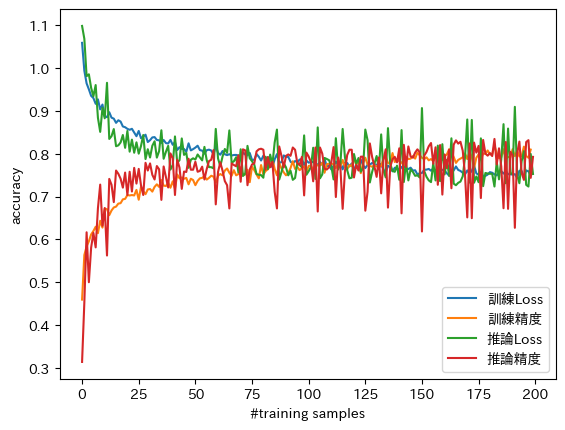

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

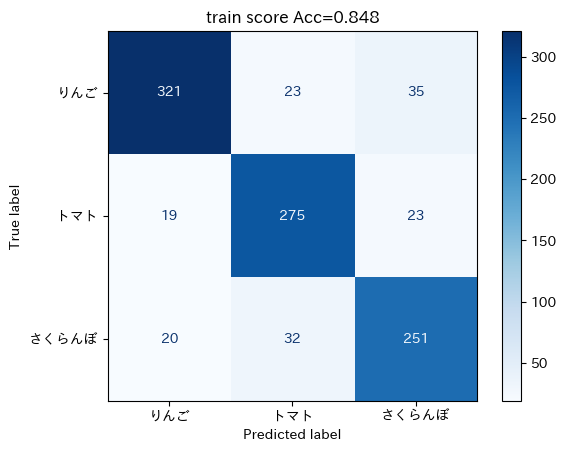

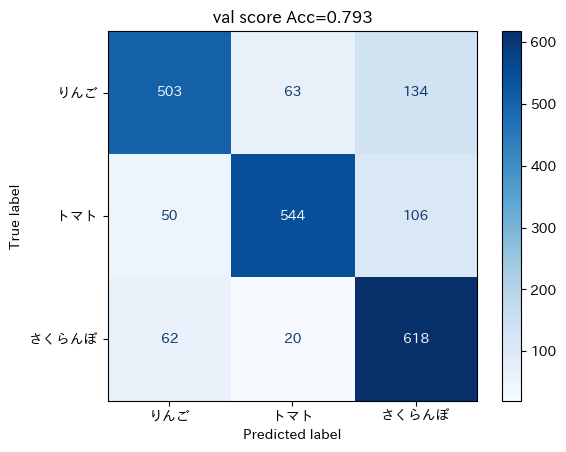

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

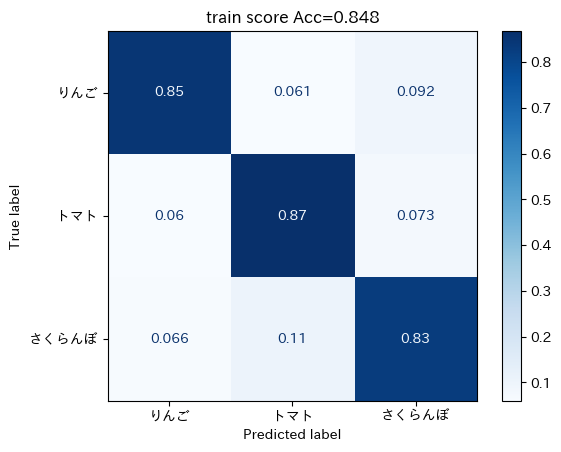

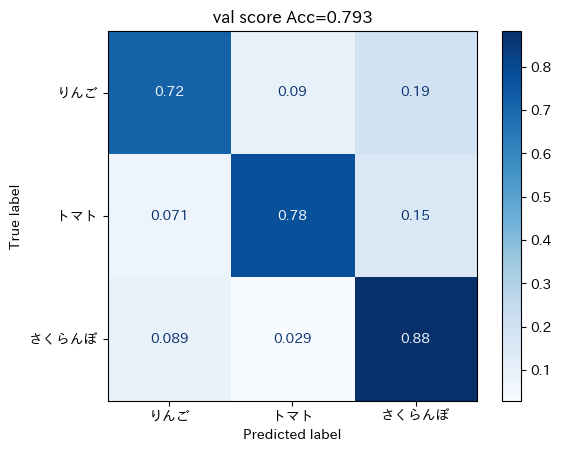

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()